# 03: Heimquote (eine ausgewählte Fragestellung aus einem Set von Fragestellungen)

Idee: "geschützte" Daten einlesen und kombinieren zu einer Datengrundlage, die so aggregiert ist, dass sie geteilt/publiziert werden kann, aber dennoch detaillierte Analysen erlaubt.


Zweck des Notebooks:
- Daten aus zwei Quellen einlesen
        1) Bevölkerung BL
        2) Heimbewohner mit Wohnort BL vor Heimeintritt in BL und ausserhalb
        Beides Datensätze, die so detailliert ohne Datenschutzvereiinbarung nicht publiziert werden.
- Hilfstabellen für Aggregationen einlesen:
        1) Gemeindezuordnung Regionen
        2) Kombi-Variable als Schlüssel (in einem separaten Notebook erstellt)
- Verknüpfen/Aggregieren
- Eine Gesamttabelle exportieren (aggregiert, Basis zur Quotenberechnung, die ohne Einschränkung publziert werden kann)

In [1]:
import pandas as pd
import numpy as np
import matplotlib #for plotting
import matplotlib.pyplot as plt #for plotting
import matplotlib.dates as mdates #for plotting 
import matplotlib.ticker as ticker #for plotting

In [2]:
ls

01_Karte_alt_aber_iO.ipynb*
01_Karte_alt_unklar.ipynb*
01_Karte_defekt.ipynb*
02_Daten.ipynb
02_heimbewohner_gereinigt.xlsx*
02_heimbewohner_gereinigt_Anaylse_Grafik.csv*
03_Quote-Extraxt_teilen_06_12_21.ipynb
03_Quote.ipynb*
Archiv_02_Daten.ipynb
Archiv_03_Quote.ipynb
Archiv_03_Quote_.ipynb
Archiv_03_Quote_1.ipynb
Heimquote_neue_VR.xlsx*
Input/
Matrix.xlsx*
Output/
Output_als_Input/
Output_weiter_mit_Excel/
Skizze_Dashboard.docx
Versionengeschichte Notebooks/
Weiterverarbeitung Excel Prototoyp/
alte versionen/
df_03_heimbewohner_bev_neu.xlsx*
test.html
~$izze_Dashboard.docx


# Bevölkerungsdaten einlesen (Bev_80+)¶

Tabelle mit Bevölkerungsdaten nach Alter und Gemeinde einlesen:

In [3]:
df_03_bev_80 = pd.read_excel ('Input/Daten/BEV/bev_80+.xlsx')
df_03_bev_80.head()

,B_GEMNR,B_GEM_Name,B_Jahr,B_Alter,B_Anzahl
0,2761,Aesch (BL),2006,80,50
1,2761,Aesch (BL),2006,81,45
2,2761,Aesch (BL),2006,82,36
3,2761,Aesch (BL),2006,83,34
4,2761,Aesch (BL),2006,84,46


Spalten umbenennen, damit ich nach dem späteren Merge kein Durcheinander bekomme.

In [4]:
df_03_bev_80.rename(columns={"GEMNR":"B_GEMNR", 
                           "GEM_Name":"B_GEM_Name", 
                           "Jahr":"B_Jahr",
                            "Alter":"B_Alter", 
                            "Anzahl":"B_Anzahl"},
                  inplace=True)
df_03_bev_80.head()

,B_GEMNR,B_GEM_Name,B_Jahr,B_Alter,B_Anzahl
0,2761,Aesch (BL),2006,80,50
1,2761,Aesch (BL),2006,81,45
2,2761,Aesch (BL),2006,82,36
3,2761,Aesch (BL),2006,83,34
4,2761,Aesch (BL),2006,84,46


In [133]:
df_03_bev_80.dtypes

B_GEMNR        int64
B_GEM_Name    object
B_Jahr         int64
B_Alter        int64
B_Anzahl       int64
dtype: object

In [134]:
df_03_bev_80['B_GEMNR'] = df_03_bev_80['B_GEMNR'].astype(str)
df_03_bev_80.dtypes

B_GEMNR       object
B_GEM_Name    object
B_Jahr         int64
B_Alter        int64
B_Anzahl       int64
dtype: object

<AxesSubplot:xlabel='B_Jahr'>

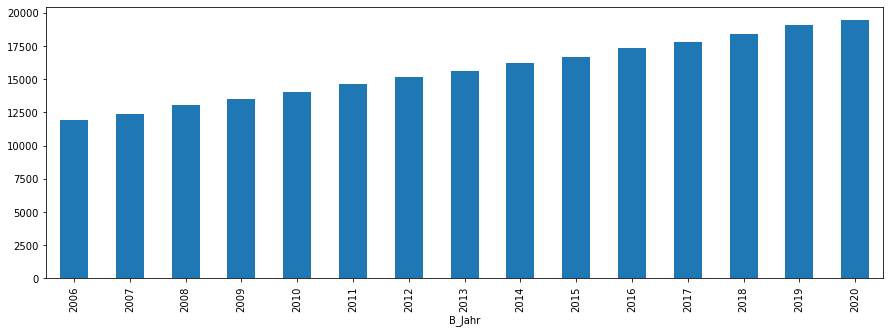

In [135]:
df_03_bev_80.groupby('B_Jahr')['B_Anzahl'].sum().plot(kind='bar',figsize=(15,5))

In [136]:
df_03_bev_80 = df_03_bev_80[(df_03_bev_80['B_Jahr'] < 2020)]
df_03_bev_80.head(1)

,B_GEMNR,B_GEM_Name,B_Jahr,B_Alter,B_Anzahl
0,2761,Aesch (BL),2006,80,50


In [137]:
df_03_bev_80 = df_03_bev_80.drop(columns=['B_GEM_Name'])
df_03_bev_80.head()

,B_GEMNR,B_Jahr,B_Alter,B_Anzahl
0,2761,2006,80,50
1,2761,2006,81,45
2,2761,2006,82,36
3,2761,2006,83,34
4,2761,2006,84,46


# Bev: neue Spalte erzeugen für spätere Verknüpfung:

In [138]:
df_03_bev_80['JAHR_GEMNR_ALTER']=df_03_bev_80['B_Jahr'].astype(str)+ '_' + df_03_bev_80['B_GEMNR'].astype(str)+ '_' + df_03_bev_80['B_Alter'].astype(str)
df_03_bev_80.head(2)

,B_GEMNR,B_Jahr,B_Alter,B_Anzahl,JAHR_GEMNR_ALTER
0,2761,2006,80,50,2006_2761_80
1,2761,2006,81,45,2006_2761_81


# APH-Daten einlesen (Heimbewohner)

In [141]:
df_03_heimbewohner = pd.read_excel ('Input/Daten/SOMED/2021-10-13_SOMED_BFS_Bewohner_31.12_n.xlsx')
df_03_heimbewohner.head(2)

,Jahr,A04_Kanton_APH,A03_Gemeinde_APH,A09_PLZ_APH,D04_Alter,D05_Kanton_Wohnort,D05_Gemeinde_Wohnort,D05_PLZ_Wohnort,D11_Beherbergung,BEWOHNER_AM_STICHTAG
0,2006,AG,NaN,NaN,83,BL,2762,4123,1,1
1,2010,GR,NaN,NaN,79,BL,2773,4153,1,1


In [142]:
df_03_heimbewohner.dtypes

Jahr                      int64
A04_Kanton_APH           object
A03_Gemeinde_APH        float64
A09_PLZ_APH             float64
D04_Alter                 int64
D05_Kanton_Wohnort       object
D05_Gemeinde_Wohnort      int64
D05_PLZ_Wohnort           int64
D11_Beherbergung          int64
BEWOHNER_AM_STICHTAG      int64
dtype: object

In [143]:
df_03_heimbewohner['A09_PLZ_APH']=df_03_heimbewohner['A09_PLZ_APH'].fillna(0)
df_03_heimbewohner

,Jahr,A04_Kanton_APH,A03_Gemeinde_APH,A09_PLZ_APH,D04_Alter,D05_Kanton_Wohnort,D05_Gemeinde_Wohnort,D05_PLZ_Wohnort,D11_Beherbergung,BEWOHNER_AM_STICHTAG
0,2006,AG,NaN,0.0,83,BL,2762,4123,1,1
1,2010,GR,NaN,0.0,79,BL,2773,4153,1,1
2,2011,GR,NaN,0.0,80,BL,2773,4153,1,1
3,2012,GR,NaN,0.0,81,BL,2773,4153,1,1
4,2016,SZ,NaN,0.0,89,BL,2849,4452,1,1
...,...,...,...,...,...,...,...,...,...,...
40087,2019,BL,2831.0,4133.0,87,BL,2762,4123,1,1
40088,2019,BL,2831.0,4133.0,89,BL,2831,4133,1,1
40089,2019,BL,2831.0,4133.0,85,BL,2831,4133,1,1
40090,2019,BL,2831.0,4133.0,88,BL,2831,4133,1,1


In [144]:
len(df_03_heimbewohner)

40092

Filter nach Wohnort BL und Alter 80+ und neue Tabelle erzeugen:

In [145]:
df_03_heimbewohner_bl = df_03_heimbewohner[(df_03_heimbewohner['D05_Kanton_Wohnort']=='BL') & (df_03_heimbewohner['D04_Alter'] > 79)]
df_03_heimbewohner_bl.head(1)

,Jahr,A04_Kanton_APH,A03_Gemeinde_APH,A09_PLZ_APH,D04_Alter,D05_Kanton_Wohnort,D05_Gemeinde_Wohnort,D05_PLZ_Wohnort,D11_Beherbergung,BEWOHNER_AM_STICHTAG
0,2006,AG,NaN,0.0,83,BL,2762,4123,1,1


In [146]:
len(df_03_heimbewohner_bl)

30951

Überflüssige Spalten löschen:

In [147]:
df_03_heimbewohner_bl = df_03_heimbewohner_bl.drop(columns=['A04_Kanton_APH', 'D05_Kanton_Wohnort', 'A03_Gemeinde_APH', 'A09_PLZ_APH', 'D05_PLZ_Wohnort', 'D11_Beherbergung'])

In [148]:
df_03_heimbewohner_bl.head()

,Jahr,D04_Alter,D05_Gemeinde_Wohnort,BEWOHNER_AM_STICHTAG
0,2006,83,2762,1
2,2011,80,2773,1
3,2012,81,2773,1
4,2016,89,2849,1
5,2016,90,2849,1


In [149]:
df_03_heimbewohner_bl['D05_Gemeinde_Wohnort'] = df_03_heimbewohner_bl['D05_Gemeinde_Wohnort'].fillna(9999)

In [150]:
df_03_heimbewohner_bl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30951 entries, 0 to 40091
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Jahr                  30951 non-null  int64
 1   D04_Alter             30951 non-null  int64
 2   D05_Gemeinde_Wohnort  30951 non-null  int64
 3   BEWOHNER_AM_STICHTAG  30951 non-null  int64
dtypes: int64(4)
memory usage: 1.2 MB


In [151]:
len(df_03_heimbewohner_bl)

30951

In [152]:
df_03_heimbewohner_bl.groupby('Jahr')['BEWOHNER_AM_STICHTAG'].sum()

Jahr
2006    1831
2007    1948
2008    1992
2009    2050
2010    2094
2011    2113
2012    2206
2013    2268
2014    2277
2015    2365
2016    2403
2017    2402
2018    2475
2019    2527
Name: BEWOHNER_AM_STICHTAG, dtype: int64

# Heimbewohner BL Spalte für Gruppierung und späteren Merge

Reminder in eigener Sache: Das Dezimalzeichen oben will ich weghaben... Woher kommt es denn plötzlich? 
Das kam aufgrund der Nulls im gelieferten Datensatz. Vor dem Import direkt im Datensatz ersetzt durch 7999 für unbekannte Gemeinde ausserhalb BL. Diesen Code nutze ich auch in der Bevölkerungsstatistik. Gut möglich, dass bei SOMED dafür eigentlich ein anderer Code benutzt wird.

Key-Spalte erzeugen für späteren merge.

In [154]:
df_03_heimbewohner_bl['JAHR_GEMNR_ALTER']=df_03_heimbewohner_bl['Jahr'].astype(str)+ '_' + df_03_heimbewohner_bl['D05_Gemeinde_Wohnort'].astype(str)+ '_' + df_03_heimbewohner_bl['D04_Alter'].astype(str)
df_03_heimbewohner_bl.head(2)

,Jahr,D04_Alter,D05_Gemeinde_Wohnort,BEWOHNER_AM_STICHTAG,JAHR_GEMNR_ALTER
0,2006,83,2762,1,2006_2762_83
2,2011,80,2773,1,2011_2773_80


In [155]:
len(df_03_heimbewohner_bl)

30951

In [156]:
df_03_heimbewohner_bl.groupby('D05_Gemeinde_Wohnort')['BEWOHNER_AM_STICHTAG'].sum()

D05_Gemeinde_Wohnort
2761    1076
2762    2642
2763    1366
2764     129
2765    1993
        ... 
2890     330
2891     208
2893     269
2894      75
2895     131
Name: BEWOHNER_AM_STICHTAG, Length: 85, dtype: int64

In [157]:
df_03_heimbewohner_bl_group=df_03_heimbewohner_bl.groupby(['JAHR_GEMNR_ALTER','Jahr', 'D04_Alter', 'D05_Gemeinde_Wohnort']).sum('BEWOHNER_AM_STICHTAG').reset_index()
df_03_heimbewohner_bl_group.head()

,JAHR_GEMNR_ALTER,Jahr,D04_Alter,D05_Gemeinde_Wohnort,BEWOHNER_AM_STICHTAG
0,2006_2761_104,2006,104,2761,1
1,2006_2761_80,2006,80,2761,2
2,2006_2761_81,2006,81,2761,4
3,2006_2761_82,2006,82,2761,3
4,2006_2761_83,2006,83,2761,4


Oben: Mit groupby zu series und mit .reset_index wieder zu df!

<AxesSubplot:xlabel='D05_Gemeinde_Wohnort'>

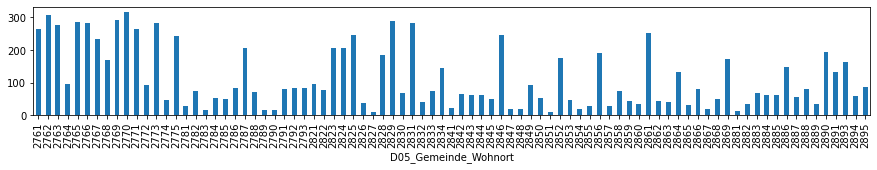

In [158]:
df_03_heimbewohner_bl_group.groupby('D05_Gemeinde_Wohnort')['BEWOHNER_AM_STICHTAG'].count().plot(kind='bar',figsize=(15,2))

In [159]:
df_03_heimbewohner_bl_group

,JAHR_GEMNR_ALTER,Jahr,D04_Alter,D05_Gemeinde_Wohnort,BEWOHNER_AM_STICHTAG
0,2006_2761_104,2006,104,2761,1
1,2006_2761_80,2006,80,2761,2
2,2006_2761_81,2006,81,2761,4
3,2006_2761_82,2006,82,2761,3
4,2006_2761_83,2006,83,2761,4
...,...,...,...,...,...
9664,2019_2895_87,2019,87,2895,1
9665,2019_2895_89,2019,89,2895,1
9666,2019_2895_90,2019,90,2895,1
9667,2019_2895_91,2019,91,2895,2


In [160]:
df_03_heimbewohner_bl_group.groupby('Jahr')['BEWOHNER_AM_STICHTAG'].sum().sort_values(ascending=True)

Jahr
2006    1831
2007    1948
2008    1992
2009    2050
2010    2094
2011    2113
2012    2206
2013    2268
2014    2277
2015    2365
2017    2402
2016    2403
2018    2475
2019    2527
Name: BEWOHNER_AM_STICHTAG, dtype: int64

In [161]:
df_03_bev_80.head(1)

,B_GEMNR,B_Jahr,B_Alter,B_Anzahl,JAHR_GEMNR_ALTER
0,2761,2006,80,50,2006_2761_80


In [162]:
df_03_bev_80.groupby('B_Jahr')['B_Anzahl'].sum()

B_Jahr
2006    11928
2007    12398
2008    13037
2009    13544
2010    14045
2011    14603
2012    15138
2013    15599
2014    16232
2015    16664
2016    17321
2017    17788
2018    18399
2019    19054
Name: B_Anzahl, dtype: int64

In [163]:
df_03_bev_80.dtypes

B_GEMNR             object
B_Jahr               int64
B_Alter              int64
B_Anzahl             int64
JAHR_GEMNR_ALTER    object
dtype: object

In [164]:
len(df_03_bev_80)

17355

<AxesSubplot:xlabel='Jahr'>

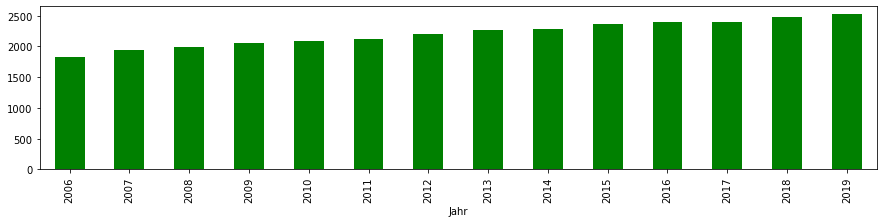

In [165]:
df_03_heimbewohner_bl_group.groupby('Jahr')['BEWOHNER_AM_STICHTAG'].sum().plot(kind='bar',figsize=(15,3), color='green')

In [166]:
df_03_heimbewohner_bl_group.groupby('Jahr')['BEWOHNER_AM_STICHTAG'].sum()

Jahr
2006    1831
2007    1948
2008    1992
2009    2050
2010    2094
2011    2113
2012    2206
2013    2268
2014    2277
2015    2365
2016    2403
2017    2402
2018    2475
2019    2527
Name: BEWOHNER_AM_STICHTAG, dtype: int64

In [167]:
df_03_heimbewohner_bl_group.groupby('D05_Gemeinde_Wohnort')['BEWOHNER_AM_STICHTAG'].sum()

D05_Gemeinde_Wohnort
2761    1076
2762    2642
2763    1366
2764     129
2765    1993
        ... 
2890     330
2891     208
2893     269
2894      75
2895     131
Name: BEWOHNER_AM_STICHTAG, Length: 85, dtype: int64

<AxesSubplot:xlabel='B_Jahr'>

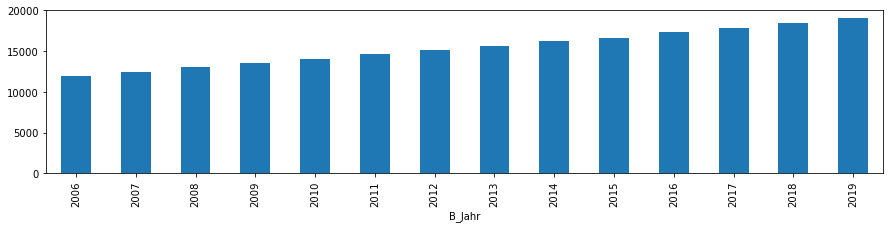

In [168]:
df_03_bev_80.groupby('B_Jahr')['B_Anzahl'].sum().plot(kind='bar',figsize=(15,3))

In [169]:
df_03_heimbewohner_bl_group['BEWOHNER_AM_STICHTAG'].sum()

30951

In [170]:
df_03_heimbewohner_bl_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9669 entries, 0 to 9668
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   JAHR_GEMNR_ALTER      9669 non-null   object
 1   Jahr                  9669 non-null   int64 
 2   D04_Alter             9669 non-null   int64 
 3   D05_Gemeinde_Wohnort  9669 non-null   int64 
 4   BEWOHNER_AM_STICHTAG  9669 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 377.8+ KB


In [171]:
df_03_heimbewohner_bl_group.dtypes

JAHR_GEMNR_ALTER        object
Jahr                     int64
D04_Alter                int64
D05_Gemeinde_Wohnort     int64
BEWOHNER_AM_STICHTAG     int64
dtype: object

In [172]:
df_03_bev_80.dtypes

B_GEMNR             object
B_Jahr               int64
B_Alter              int64
B_Anzahl             int64
JAHR_GEMNR_ALTER    object
dtype: object

In [173]:
df_03_bev_80_group=df_03_bev_80.groupby(['JAHR_GEMNR_ALTER','B_Jahr', 'B_Alter', 'B_GEMNR']).sum('B_Anzahl').reset_index()
df_03_bev_80_group.head()

,JAHR_GEMNR_ALTER,B_Jahr,B_Alter,B_GEMNR,B_Anzahl
0,2006_2761_100,2006,100,2761,1
1,2006_2761_104,2006,104,2761,1
2,2006_2761_80,2006,80,2761,50
3,2006_2761_81,2006,81,2761,45
4,2006_2761_82,2006,82,2761,36


Oben: Mit groupby zu series und mit .reset_index wieder zu df!

# Bei beiden zusammenzuführenden Tabellen die komblette Liste der JAHR_GEMNR_ALTER Spalte einlesen um spätere Division durch Null zu vermeiden.

In [191]:
kombi_variable= pd.read_excel('Input/Zuordnungen/kombi_alter.xlsx') #Kompletter Schlüssel aus drei Merkmalen. Sonst gibt es Probleme bei der Quotenberechnung.
kombi_variable.head()

,Unnamed: 0,JAHR_GEMNR_ALTER,Jahr_agg,GEMNR_agg,Alter_agg
0,0,2006_2761_80,2006,2761,80
1,1,2006_2761_81,2006,2761,81
2,2,2006_2761_82,2006,2761,82
3,3,2006_2761_83,2006,2761,83
4,4,2006_2761_84,2006,2761,84


In [230]:
kombi_variable.shape

(40455, 5)

Altersklassen einlesen zum mergen mit kombi_variable

In [192]:
alter_80= pd.read_excel ('Input/Zuordnungen/altersklassen_80+.xlsx') #Kompletter Schlüssel aus drei Merkmalen. Sonst gibt es Probleme bei der Quotenberechnung.
alter_80.head()

,Alter,Alter_5_kl,Alter_100+
0,80,1 | 80-84,1 | 80
1,81,1 | 80-84,2 | 81
2,82,1 | 80-84,3 | 82
3,83,1 | 80-84,4 | 83
4,84,1 | 80-84,5 | 84


In [193]:
kombi_alter_80=pd.merge(kombi_variable, alter_80, how='left', left_on='Alter_agg', right_on='Alter')
kombi_alter_80

,Unnamed: 0,JAHR_GEMNR_ALTER,Jahr_agg,GEMNR_agg,Alter_agg,Alter,Alter_5_kl,Alter_100+
0,0,2006_2761_80,2006,2761,80,80,1 | 80-84,1 | 80
1,1,2006_2761_81,2006,2761,81,81,1 | 80-84,2 | 81
2,2,2006_2761_82,2006,2761,82,82,1 | 80-84,3 | 82
3,3,2006_2761_83,2006,2761,83,83,1 | 80-84,4 | 83
4,4,2006_2761_84,2006,2761,84,84,1 | 80-84,5 | 84
...,...,...,...,...,...,...,...,...
40450,40450,2020_8999_106,2020,8999,106,106,6 | 105-109,21 | 100+
40451,40451,2020_8999_107,2020,8999,107,107,6 | 105-109,21 | 100+
40452,40452,2020_8999_108,2020,8999,108,108,6 | 105-109,21 | 100+
40453,40453,2020_8999_109,2020,8999,109,109,6 | 105-109,21 | 100+


In [232]:
kombi_alter_80.shape

(40455, 8)

Zuordnung Gemeinden einlesen zum mergen mit kombi_variable

In [194]:
vr = pd.read_excel('Input/Zuordnungen/Gem_VR_12_21_agg.xlsx')
vr.head(1)

,GMDNR,VR_APH_12_2021_agg,VR_Wohnort_12_2021_agg
0,2761,3 | VR Alter Birsstadt,3 | VR Alter Birsstadt


In [195]:
kombi_alter_80_vr=pd.merge(kombi_alter_80, vr, how='left', left_on='GEMNR_agg', right_on='GMDNR')
kombi_alter_80_vr

,Unnamed: 0,JAHR_GEMNR_ALTER,Jahr_agg,GEMNR_agg,Alter_agg,Alter,Alter_5_kl,Alter_100+,GMDNR,VR_APH_12_2021_agg,VR_Wohnort_12_2021_agg
0,0,2006_2761_80,2006,2761,80,80,1 | 80-84,1 | 80,2761.0,3 | VR Alter Birsstadt,3 | VR Alter Birsstadt
1,1,2006_2761_81,2006,2761,81,81,1 | 80-84,2 | 81,2761.0,3 | VR Alter Birsstadt,3 | VR Alter Birsstadt
2,2,2006_2761_82,2006,2761,82,82,1 | 80-84,3 | 82,2761.0,3 | VR Alter Birsstadt,3 | VR Alter Birsstadt
3,3,2006_2761_83,2006,2761,83,83,1 | 80-84,4 | 83,2761.0,3 | VR Alter Birsstadt,3 | VR Alter Birsstadt
4,4,2006_2761_84,2006,2761,84,84,1 | 80-84,5 | 84,2761.0,3 | VR Alter Birsstadt,3 | VR Alter Birsstadt
...,...,...,...,...,...,...,...,...,...,...,...
40450,40450,2020_8999_106,2020,8999,106,106,6 | 105-109,21 | 100+,NaN,NaN,NaN
40451,40451,2020_8999_107,2020,8999,107,107,6 | 105-109,21 | 100+,NaN,NaN,NaN
40452,40452,2020_8999_108,2020,8999,108,108,6 | 105-109,21 | 100+,NaN,NaN,NaN
40453,40453,2020_8999_109,2020,8999,109,109,6 | 105-109,21 | 100+,NaN,NaN,NaN


In [233]:
kombi_alter_80_vr.shape

(40455, 7)

In [197]:
kombi_alter_80_vr.drop(columns=['Unnamed: 0', 'VR_Wohnort_12_2021_agg', 'Alter', 'GEMNR_agg'], inplace=True)
kombi_alter_80_vr

,JAHR_GEMNR_ALTER,Jahr_agg,Alter_agg,Alter_5_kl,Alter_100+,GMDNR,VR_APH_12_2021_agg
0,2006_2761_80,2006,80,1 | 80-84,1 | 80,2761.0,3 | VR Alter Birsstadt
1,2006_2761_81,2006,81,1 | 80-84,2 | 81,2761.0,3 | VR Alter Birsstadt
2,2006_2761_82,2006,82,1 | 80-84,3 | 82,2761.0,3 | VR Alter Birsstadt
3,2006_2761_83,2006,83,1 | 80-84,4 | 83,2761.0,3 | VR Alter Birsstadt
4,2006_2761_84,2006,84,1 | 80-84,5 | 84,2761.0,3 | VR Alter Birsstadt
...,...,...,...,...,...,...,...
40450,2020_8999_106,2020,106,6 | 105-109,21 | 100+,NaN,NaN
40451,2020_8999_107,2020,107,6 | 105-109,21 | 100+,NaN,NaN
40452,2020_8999_108,2020,108,6 | 105-109,21 | 100+,NaN,NaN
40453,2020_8999_109,2020,109,6 | 105-109,21 | 100+,NaN,NaN


In [198]:
kombi_alter_80_vr.rename(columns={'Alter_5_kl': 'Alter_5_agg','Alter_100+': 'Alter_100+_agg','GMDNR': 'GMDNR_agg'}, inplace=True)
kombi_alter_80_vr

,JAHR_GEMNR_ALTER,Jahr_agg,Alter_agg,Alter_5_agg,Alter_100+_agg,GMDNR_agg,VR_APH_12_2021_agg
0,2006_2761_80,2006,80,1 | 80-84,1 | 80,2761.0,3 | VR Alter Birsstadt
1,2006_2761_81,2006,81,1 | 80-84,2 | 81,2761.0,3 | VR Alter Birsstadt
2,2006_2761_82,2006,82,1 | 80-84,3 | 82,2761.0,3 | VR Alter Birsstadt
3,2006_2761_83,2006,83,1 | 80-84,4 | 83,2761.0,3 | VR Alter Birsstadt
4,2006_2761_84,2006,84,1 | 80-84,5 | 84,2761.0,3 | VR Alter Birsstadt
...,...,...,...,...,...,...,...
40450,2020_8999_106,2020,106,6 | 105-109,21 | 100+,NaN,NaN
40451,2020_8999_107,2020,107,6 | 105-109,21 | 100+,NaN,NaN
40452,2020_8999_108,2020,108,6 | 105-109,21 | 100+,NaN,NaN
40453,2020_8999_109,2020,109,6 | 105-109,21 | 100+,NaN,NaN


# Heimbewohner anschauen zum mergen mit kombi_variable

In [199]:
df_03_heimbewohner_bl

,Jahr,D04_Alter,D05_Gemeinde_Wohnort,BEWOHNER_AM_STICHTAG,JAHR_GEMNR_ALTER
0,2006,83,2762,1,2006_2762_83
2,2011,80,2773,1,2011_2773_80
3,2012,81,2773,1,2012_2773_81
4,2016,89,2849,1,2016_2849_89
5,2016,90,2849,1,2016_2849_90
...,...,...,...,...,...
40087,2019,87,2762,1,2019_2762_87
40088,2019,89,2831,1,2019_2831_89
40089,2019,85,2831,1,2019_2831_85
40090,2019,88,2831,1,2019_2831_88


In [200]:
df_03_heimbewohner_bl.groupby('Jahr')['BEWOHNER_AM_STICHTAG'].sum()

Jahr
2006    1831
2007    1948
2008    1992
2009    2050
2010    2094
2011    2113
2012    2206
2013    2268
2014    2277
2015    2365
2016    2403
2017    2402
2018    2475
2019    2527
Name: BEWOHNER_AM_STICHTAG, dtype: int64

In [201]:
df_03_heimbewohner_bl.drop(columns=['Jahr', 'D04_Alter', 'D05_Gemeinde_Wohnort'], inplace=True)
df_03_heimbewohner_bl.rename(columns={'BEWOHNER_AM_STICHTAG': 'BEWOHNER_AM_STICHTAG_Wohnort'}, inplace=True)
df_03_heimbewohner_bl

,BEWOHNER_AM_STICHTAG_Wohnort,JAHR_GEMNR_ALTER
0,1,2006_2762_83
2,1,2011_2773_80
3,1,2012_2773_81
4,1,2016_2849_89
5,1,2016_2849_90
...,...,...
40087,1,2019_2762_87
40088,1,2019_2831_89
40089,1,2019_2831_85
40090,1,2019_2831_88


In [202]:
df_03_heimbewohner_bl.shape

(30951, 2)

In [203]:
kombi_alter_80_vr.shape

(40455, 7)

In [242]:
df_03_heimbewohner_bl_grouped=df_03_heimbewohner_bl.groupby('JAHR_GEMNR_ALTER')['BEWOHNER_AM_STICHTAG_Wohnort'].sum()
df_03_heimbewohner_bl_grouped

JAHR_GEMNR_ALTER
2006_2761_104    1
2006_2761_80     2
2006_2761_81     4
2006_2761_82     3
2006_2761_83     4
                ..
2019_2895_87     1
2019_2895_89     1
2019_2895_90     1
2019_2895_91     2
2019_2895_98     1
Name: BEWOHNER_AM_STICHTAG_Wohnort, Length: 9669, dtype: int64

In [243]:
kombi_alter_80_vr_hb=pd.merge(kombi_alter_80_vr, df_03_heimbewohner_bl_grouped, how='left', on='JAHR_GEMNR_ALTER')
kombi_alter_80_vr_hb

,JAHR_GEMNR_ALTER,Jahr_agg,Alter_agg,Alter_5_agg,Alter_100+_agg,GMDNR_agg,VR_APH_12_2021_agg,BEWOHNER_AM_STICHTAG_Wohnort
0,2006_2761_80,2006,80,1 | 80-84,1 | 80,2761.0,3 | VR Alter Birsstadt,2.0
1,2006_2761_81,2006,81,1 | 80-84,2 | 81,2761.0,3 | VR Alter Birsstadt,4.0
2,2006_2761_82,2006,82,1 | 80-84,3 | 82,2761.0,3 | VR Alter Birsstadt,3.0
3,2006_2761_83,2006,83,1 | 80-84,4 | 83,2761.0,3 | VR Alter Birsstadt,4.0
4,2006_2761_84,2006,84,1 | 80-84,5 | 84,2761.0,3 | VR Alter Birsstadt,6.0
...,...,...,...,...,...,...,...,...
40450,2020_8999_106,2020,106,6 | 105-109,21 | 100+,NaN,NaN,NaN
40451,2020_8999_107,2020,107,6 | 105-109,21 | 100+,NaN,NaN,NaN
40452,2020_8999_108,2020,108,6 | 105-109,21 | 100+,NaN,NaN,NaN
40453,2020_8999_109,2020,109,6 | 105-109,21 | 100+,NaN,NaN,NaN


In [244]:
kombi_alter_80_vr_hb.groupby('Jahr_agg')['BEWOHNER_AM_STICHTAG_Wohnort'].sum()
#Im Jahr 2014 ist eine Person verschwunden!!!!

Jahr_agg
2006    1831.0
2007    1948.0
2008    1992.0
2009    2050.0
2010    2094.0
2011    2113.0
2012    2206.0
2013    2268.0
2014    2277.0
2015    2365.0
2016    2403.0
2017    2402.0
2018    2475.0
2019    2527.0
2020       0.0
Name: BEWOHNER_AM_STICHTAG_Wohnort, dtype: float64

# Hier Bev dazumergen

In [222]:
df_03_bev_80

,B_GEMNR,B_Jahr,B_Alter,B_Anzahl,JAHR_GEMNR_ALTER
0,2761,2006,80,50,2006_2761_80
1,2761,2006,81,45,2006_2761_81
2,2761,2006,82,36,2006_2761_82
3,2761,2006,83,34,2006_2761_83
4,2761,2006,84,46,2006_2761_84
...,...,...,...,...,...
18665,2895,2019,91,4,2019_2895_91
18666,2895,2019,93,3,2019_2895_93
18667,2895,2019,94,1,2019_2895_94
18668,2895,2019,95,1,2019_2895_95


In [245]:
df_03_bev_80.groupby('B_Jahr')['B_Anzahl'].sum()

B_Jahr
2006    11928
2007    12398
2008    13037
2009    13544
2010    14045
2011    14603
2012    15138
2013    15599
2014    16232
2015    16664
2016    17321
2017    17788
2018    18399
2019    19054
Name: B_Anzahl, dtype: int64

In [246]:
df_03_bev_80_schmal=df_03_bev_80.drop(columns=['B_GEMNR', 'B_Jahr', 'B_Alter'])
df_03_bev_80_schmal

,B_Anzahl,JAHR_GEMNR_ALTER
0,50,2006_2761_80
1,45,2006_2761_81
2,36,2006_2761_82
3,34,2006_2761_83
4,46,2006_2761_84
...,...,...
18665,4,2019_2895_91
18666,3,2019_2895_93
18667,1,2019_2895_94
18668,1,2019_2895_95


In [247]:
#kombi_alter_80vr_hb_kombi=pd.merge(kombi_alter_80vr_hb, kombi_variable,  how='right', left_on='JAHR_GEMNR_ALTER', right_on='JAHR_GEMNR_ALTER')
#kombi_alter_80vr_hb_kombi

In [350]:
kombi_alter_80vr_hb_bev=pd.merge(kombi_alter_80_vr_hb, df_03_bev_80_schmal,  how='left', on='JAHR_GEMNR_ALTER')
kombi_alter_80vr_hb_bev

,JAHR_GEMNR_ALTER,Jahr_agg,Alter_agg,Alter_5_agg,Alter_100+_agg,GMDNR_agg,VR_APH_12_2021_agg,BEWOHNER_AM_STICHTAG_Wohnort,B_Anzahl
0,2006_2761_80,2006,80,1 | 80-84,1 | 80,2761.0,3 | VR Alter Birsstadt,2.0,50.0
1,2006_2761_81,2006,81,1 | 80-84,2 | 81,2761.0,3 | VR Alter Birsstadt,4.0,45.0
2,2006_2761_82,2006,82,1 | 80-84,3 | 82,2761.0,3 | VR Alter Birsstadt,3.0,36.0
3,2006_2761_83,2006,83,1 | 80-84,4 | 83,2761.0,3 | VR Alter Birsstadt,4.0,34.0
4,2006_2761_84,2006,84,1 | 80-84,5 | 84,2761.0,3 | VR Alter Birsstadt,6.0,46.0
...,...,...,...,...,...,...,...,...,...
40450,2020_8999_106,2020,106,6 | 105-109,21 | 100+,NaN,NaN,NaN,NaN
40451,2020_8999_107,2020,107,6 | 105-109,21 | 100+,NaN,NaN,NaN,NaN
40452,2020_8999_108,2020,108,6 | 105-109,21 | 100+,NaN,NaN,NaN,NaN
40453,2020_8999_109,2020,109,6 | 105-109,21 | 100+,NaN,NaN,NaN,NaN


In [351]:
#kombi_alter_80vr_hb_bev.drop(columns=['B_GEMNR', 'B_Jahr', 'B_Alter'], inplace=True)
#kombi_alter_80vr_hb_bev

In [352]:
kombi_alter_80vr_hb_bev.groupby('Jahr_agg')['B_Anzahl'].sum()

Jahr_agg
2006    11928.0
2007    12398.0
2008    13037.0
2009    13544.0
2010    14045.0
2011    14603.0
2012    15138.0
2013    15599.0
2014    16232.0
2015    16664.0
2016    17321.0
2017    17788.0
2018    18399.0
2019    19054.0
2020        0.0
Name: B_Anzahl, dtype: float64

# Die Tabelle ist fertig und kann so geteilt werden (aggregiert, Basis für Berechnung der Quoten nach unterschiedlichen Ausprägungen)

In [353]:
kombi_alter_80vr_hb_bev.to_excel('Output_weiter_mit_Excel/kombi_alter_80bl_vr_bev_def.xlsx')

# Plots erstellen

# Plots Regionen 2019

In [354]:
kombi_alter_80vr_hb_bev.head(1)

,JAHR_GEMNR_ALTER,Jahr_agg,Alter_agg,Alter_5_agg,Alter_100+_agg,GMDNR_agg,VR_APH_12_2021_agg,BEWOHNER_AM_STICHTAG_Wohnort,B_Anzahl
0,2006_2761_80,2006,80,1 | 80-84,1 | 80,2761.0,3 | VR Alter Birsstadt,2.0,50.0


In [363]:
kombi_alter_80vr_hb_bev_2019= kombi_alter_80vr_hb_bev[kombi_alter_80vr_hb_bev['Jahr_agg'] == 2019]

In [368]:
df_quote_jahr=kombi_alter_80vr_hb_bev_2019.groupby('VR_APH_12_2021_agg').sum()

In [369]:
df_quote_jahr.insert(loc=len(df_quote_jahr.columns),
           column='Anteil',
           value=(df_quote_jahr['BEWOHNER_AM_STICHTAG_Wohnort']/df_quote_jahr['B_Anzahl']*100))
df_quote_jahr

,Jahr_agg,Alter_agg,GMDNR_agg,BEWOHNER_AM_STICHTAG_Wohnort,B_Anzahl,Anteil
VR_APH_12_2021_agg,,,,,,
1 | VR Alter und Gesundheit ABS,187767,8835,257331.0,375.0,2943.0,12.742100
2 | VR APG Rheintal,312945,14725,434465.0,526.0,3365.0,15.631501
3 | VR Alter Birsstadt,375534,17670,515313.0,515.0,4205.0,12.247325
4 | VR BPA Leimental,375534,17670,515468.0,258.0,2621.0,9.843571
5 | VR APG Laufental,688479,32395,950553.0,116.0,885.0,13.107345
6 | VR Alters- und Pflegeregion Liestal,625890,29450,876494.0,319.0,2349.0,13.580247
7 | VR Oberbaselbiet / VR Oberes Homburgertal,1940259,91295,2745484.0,297.0,1938.0,15.325077
8 | VR Waldenburgertal plus,876246,41230,1251873.0,121.0,748.0,16.176471


<AxesSubplot:ylabel='VR_APH_12_2021_agg'>

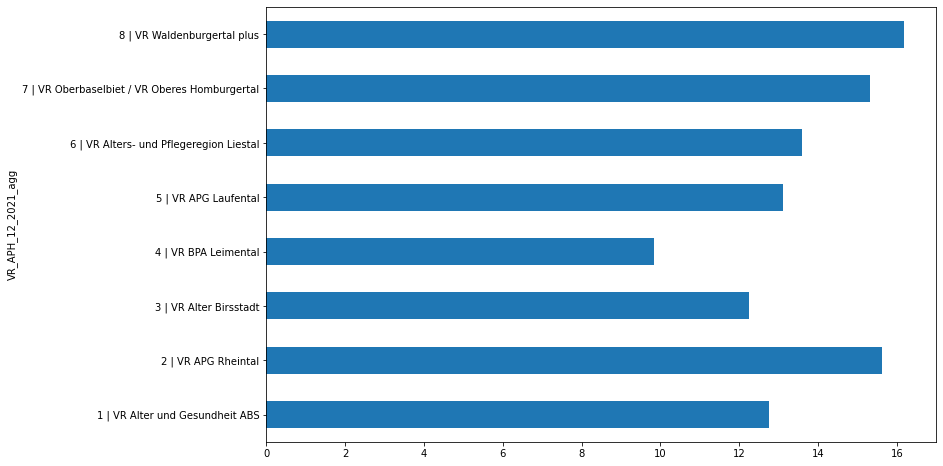

In [372]:
df_quote_jahr['Anteil'].plot(kind='barh',figsize=(12,8))

# Plots Quote Alter

In [408]:
df_quote_alter=kombi_alter_80vr_hb_bev_2019.groupby('Alter_100+_agg').sum()

In [409]:
df_quote_alter.insert(loc=len(df_quote_alter.columns),
           column='Anteil',
           value=(df_quote_alter['BEWOHNER_AM_STICHTAG_Wohnort']/df_quote_alter['B_Anzahl']*100))
df_quote_alter.sort_values('Alter_agg',ascending=True, inplace=True)

<AxesSubplot:xlabel='Alter_100+_agg'>

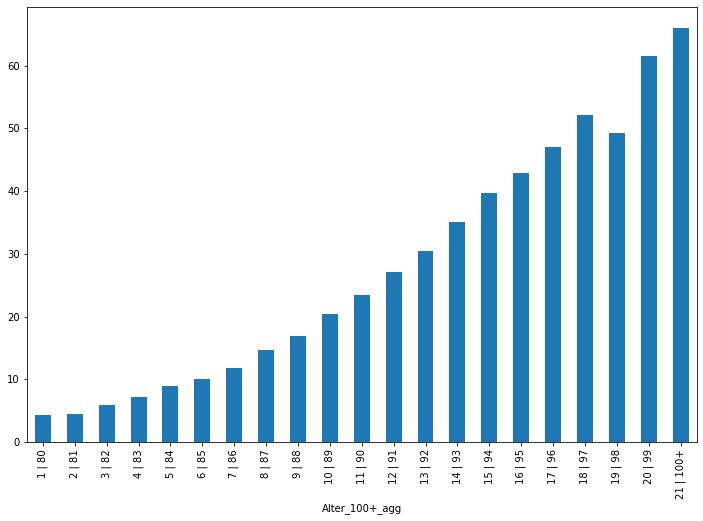

In [410]:
df_quote_alter['Anteil'].plot(kind='bar',figsize=(12,8))

# Hier stoppen

# ALTE Quotenberechnung (neu alles oben erledigt, ausser plots)

In [68]:
df_03_heimbewohner_bev[['BEWOHNER_AM_STICHTAG', 'B_Anzahl']]=df_03_heimbewohner_bev[['BEWOHNER_AM_STICHTAG', 'B_Anzahl']].fillna(0)
df_03_heimbewohner_bev
#df.fillna(0)
#df_03_heimbewohner_bev.convert_dtypes()
#df_03_heimbewohner_bev.dtypes

,JAHR_GEMNR_ALTER,D05_Gemeinde_Wohnort,BEWOHNER_AM_STICHTAG,B_Anzahl
0,2006_2761_104,2761.0,1.0,1.0
1,2006_2761_80,2761.0,2.0,50.0
2,2006_2761_81,2761.0,4.0,45.0
3,2006_2761_82,2761.0,3.0,36.0
4,2006_2761_83,2761.0,4.0,34.0
...,...,...,...,...
17589,2019_2895_86,NaN,0.0,2.0
17590,2019_2895_88,NaN,0.0,1.0
17591,2019_2895_93,NaN,0.0,3.0
17592,2019_2895_94,NaN,0.0,1.0


In [69]:
df_03_heimbewohner_bev['BEWOHNER_AM_STICHTAG'].sum()

30951.0

In [70]:
df_03_heimbewohner_bev.groupby('Jahr')['BEWOHNER_AM_STICHTAG'].sum()

KeyError: 'Jahr'

In [ ]:
# beschreiben wozu.... df_03_heimbewohner_bev.to_csv('Output_als_Input/hb_bev.csv')

In [ ]:
df_03_heimbewohner_bev.dtypes

In [ ]:
len(df_03_heimbewohner_bev)

In [ ]:
df_03_heimbewohner_bev.groupby('B_GEMNR')['B_Anzahl'].sum()

In [ ]:
df_03_heimbewohner_bev.groupby('B_Jahr')['BEWOHNER_AM_STICHTAG'].sum().plot(kind='bar',figsize=(15,3), color='green')

In [ ]:
df_03_heimbewohner_bev.groupby('B_Jahr')['B_Anzahl'].sum().plot(kind='bar',figsize=(15,3))

In [ ]:
df_03_heimbewohner_bev.to_csv('Output_weiter_mit_Excel/hb_bev.csv')
df_03_heimbewohner_bl_group.to_csv('Output_weiter_mit_Excel/hb.csv')

# Tabelle mit Zuordnung Wohngemeinde - Versorgungsregion einlesen

In [ ]:
#df_regions = pd.read_excel('Input/Zuordnungen/Gem_VR_12_21_agg.xlsx') #Auskommentiert, da schon oben eingelesen
#df_regions.head(1)

In [ ]:
df_regions = df_regions.rename(columns={'GMDNR': 'GMDNR_agg'})
df_regions.head(1)

In [ ]:
#df_regions=df_regions.set_index('GMDNR') #Macht das Sinn???? Ich habe das gemacht, damit die GMDNR unten nicht auch angefügt wird.

In [ ]:
#df_regions.groupby('GMDNR_agg').sum()

In [ ]:
#df_regions_wohnort = df_regions.drop(columns=['VR_APH_12_2021_agg'])
#df_regions_wohnort.head()

In [ ]:
# Das muss ich machen, damit der Merge weiter unten funktioniert. Ist sicher etwas doof, aber schränkt bis jetzt nicht weiter ein.
df_03_heimbewohner_bev['B_GEMNR'] = df_03_heimbewohner_bev['B_GEMNR'].astype(float) 
#df_03_heimbewohner_bev.head(1)

In [ ]:
# df_03_heimbewohner_bev['B_GEMNR'] = df_03_heimbewohner_bev['B_GEMNR'].str.replace("\.0$", "")

In [ ]:
#df_03_heimbewohner_bev['B_GEMNR'].str.split('.', expand=True)

In [ ]:
df_03_heimbewohner_bev.head(10)

In [ ]:
df_regions.head(1) #Nochmals, um den Variablennamen zu sehen.

In [ ]:
# Dieser Schritt ist gar nicht nötig! Es funktioniert trotzdem
#df_regions_wohnort['GMDNR'] = df_regions_wohnort['GMDNR'].astype(float) #Damit die Spalten das gleiche Format haben und ich mergen kann
#df_regions_wohnort.head(1)

In [ ]:
df_03_heimbewohner_bev=pd.merge(df_03_heimbewohner_bev, df_regions, how='left', left_on=['B_GEMNR'], right_on=['GMDNR_agg'])
df_03_heimbewohner_bev.head(10)

In [ ]:
len(df_03_heimbewohner_bev)

In [ ]:
df_03_heimbewohner_bev.to_csv('Output_weiter_mit_Excel/somed_bev_vr_agg.csv')

In [ ]:
df_03_heimbewohner_bev.groupby('B_Jahr')['B_Anzahl'].sum()

In [ ]:
df_03_heimbewohner_bev.groupby('Jahr')['BEWOHNER_AM_STICHTAG'].sum()

In [ ]:
df_03_heimbewohner_bev.groupby('VR_APH_12_2021_agg')['BEWOHNER_AM_STICHTAG'].sum()

In [ ]:
df_03_heimbewohner_bev.groupby('B_GEMNR')['BEWOHNER_AM_STICHTAG'].sum()

In [ ]:
df_03_heimbewohner_bev

In [ ]:
df_03_heimbewohner_bev[['A_Jahr','A_Gem', 'A_Alter']] = df_03_heimbewohner_bev.JAHR_GEMNR_ALTER.str.split("_",expand=True,)
df_03_heimbewohner_bev

In [ ]:
df_03_heimbewohner_bev_ausw=df_03_heimbewohner_bev[['A_Jahr', 'A_Gem', 'VR_APH_12_2021_agg', 'A_Alter', 'B_Anzahl','BEWOHNER_AM_STICHTAG']]
df_03_heimbewohner_bev_ausw

In [ ]:
df_03_heimbewohner_bev_ausw.fillna(0)

In [ ]:
#df_03_heimbewohner_bev_ausw['A_Alter'] = df_03_heimbewohner_bev_ausw['A_Alter'].astype(int)

In [ ]:
#df_03_heimbewohner_bev_ausw[['B_Anzahl','BEWOHNER_AM_STICHTAG']]= df_03_heimbewohner_bev_ausw[['B_Anzahl', 'BEWOHNER_AM_STICHTAG']].fillna(0)

In [ ]:
#df_03_heimbewohner_bev_ausw

In [ ]:
#df_03_heimbewohner_bev_ausw.convert_dtypes()

In [ ]:
#df_03_heimbewohner_bev_ausw

In [ ]:
#df_03_heimbewohner_bev_ausw=df_03_heimbewohner_bev_ausw['B_Anzahl'].astype(float)

In [ ]:
df_03_heimbewohner_bev_ausw.groupby('A_Jahr')['BEWOHNER_AM_STICHTAG'].sum().plot(figsize=(15,2))

In [ ]:
df_03_heimbewohner_bev_ausw.groupby('A_Jahr')['B_Anzahl'].sum().plot(figsize=(15,2))

In [ ]:
#df_03_heimbewohner_bev_ausw

In [ ]:
#df_03_heimbewohner_bev_ausw.groupby('A_Jahr')['Anteil'].sum().plot(figsize=(15,2))

In [ ]:
#df_03_heimbewohner_bev_ausw.groupby('A_Jahr')['Anteil'].sum().plot(kind='bar',figsize=(15,3), color='green')

# Quote Total - nach Jahr

In [ ]:
df_03_heimbewohner_bev_ausw.head(1)

In [ ]:
#Ich muss Schritte aufteilen, die ich alle auf einmal machen wollte...
df_quote_jahr=df_03_heimbewohner_bev_ausw.drop(columns=['A_Gem', 'A_Alter', 'VR_APH_12_2021_agg'])
df_quote_jahr.head(1)

In [ ]:
df_quote_jahr=df_quote_jahr.groupby(['A_Jahr']).sum()
df_quote_jahr

In [ ]:
df_quote_jahr.insert(loc=len(df_quote_jahr.columns),
           column='Anteil',
           value=(df_quote_jahr['BEWOHNER_AM_STICHTAG']/df_quote_jahr['B_Anzahl']*100))
df_quote_jahr

In [ ]:
df_quote_jahr['Anteil'].plot(kind='bar',title='Anteil der 80+ in einem Pflegeheim gemessen an der gleichenaltrigen Wohnbevölkerung BL',figsize=(15,5))

# Quote Regionen nach Jahr

In [ ]:
df_quote_region_jahr.insert(loc=len(df_quote_region_jahr.columns),
           column='Anteil',
           value=(df_quote_region_jahr['BEWOHNER_AM_STICHTAG']/df_quote_region_jahr['B_Anzahl']*100))
df_quote_region_jahr

In [ ]:
#df_quote_region_jahr.to_csv('Output_als_Input/quote_jahr_neu.csv') # Momentan nicht nötig

In [ ]:
df_quote_region_jahr['Anteil'].unstack('VR_APH_12_2021_agg').plot(figsize=(12,8))

In [ ]:
df_quote_region_jahr['Anteil'].unstack('A_Jahr').plot(kind='bar', figsize=(12,6))

# Quote Alter - für alle Jahre kummuliert (explorativ)

In [ ]:
#Ich muss Schritte aufteilen, die ich alle auf einmal machen wollte...
df_quote_alter=df_03_heimbewohner_bev_ausw.drop(columns=['A_Gem', 'VR_APH_12_2021_agg'])
df_quote_alter.sort_values('A_Alter').head(1)

In [ ]:
df_quote_alter['A_Alter'] = df_quote_alter['A_Alter'].astype(int)
#zwischenzeitlich weiter oben erledigt

In [ ]:
df_quote_alter=df_quote_alter.sort_values(['A_Alter'],ascending=True).groupby(['A_Alter']).sum()
df_quote_alter.reset_index()

In [ ]:
df_quote_alter.insert(loc=len(df_quote_alter.columns),
           column='Anteil',
           value=(df_quote_alter['BEWOHNER_AM_STICHTAG']/df_quote_alter['B_Anzahl']*100))
df_quote_alter.reset_index()

In [ ]:
df_quote_alter['Anteil'].plot(kind='bar', y='Heimquote', title='Anteil der 80+ in einem Pflegeheim gemessen an der gleichenaltrigen Wohnbevölkerung BL',figsize=(15,5))

# Quote Regionen/Alter - alle Jahre kummuliert (explorativ)

In [ ]:
#Ich muss Schritte aufteilen, die ich alle auf einmal machen wollte...
df_quote_region_alter_vorb=df_03_heimbewohner_bev_ausw.drop(columns=['A_Gem'])
df_quote_region_alter_vorb.head(1)

In [ ]:
df_quote_region_alter_vorb.dtypes

In [ ]:
df_quote_region_alter_vorb['A_Alter'] = df_quote_region_alter_vorb['A_Alter'].astype(int)
#zwischenzeitlich weiter oben erledigt

In [ ]:
df_quote_region_alter=df_quote_region_alter_vorb.groupby(['VR_APH_12_2021_agg','A_Alter']).sum()

In [ ]:
#df_quote_region_alter.reset_index(inplace=True)

In [ ]:
df_quote_region_alter.insert(loc=len(df_quote_region_alter.columns),
           column='Anteil',
           value=(df_quote_region_alter['BEWOHNER_AM_STICHTAG']/df_quote_region_alter['B_Anzahl']*100))
df_quote_region_alter

In [ ]:
#df_quote_region_alter=df_quote_region_alter.reset_index()

In [ ]:
df_quote_region_alter.dtypes

In [ ]:
df_quote_region_alter.columns

In [ ]:
df_quote_region_alter['Anteil'].unstack('VR_APH_12_2021_agg').plot(figsize=(12,6))

In [ ]:
df_quote_region_jahr['Anteil'].unstack('VR_APH_12_2021_agg').plot(figsize=(12,6))